# Imports and parameters

In [1]:
# local imports
from scripts.data import *
from scripts.nn import *
from scripts.loss import *

# data manipulation
import torch
from torch import nn, optim
import numpy as np
import os
import pandas as pd

# visualization
import matplotlib.pyplot as plt

In [2]:
N_STEPS = 100
N_SIMULATIONS = 200
MIN_X, MAX_X = [-10, 10]
MIN_Y, MAX_Y = [-10, 10]
N_ANCHORS = 5

DATA_PATH = 'data/'
SIMULATIONS_FILE_NAME = os.path.join(DATA_PATH, 'generated_simulations_n.pt')
ANCHORS_FILE_NAME = os.path.join(DATA_PATH, 'anchors_pos.pt')
CAL_FILE_NAME = os.path.join(DATA_PATH, 'calibration_data')

RESULTS_PATH = 'results/'

In [3]:
BATCH_SIZE = 1
N_EPOCHS = 500

# Generate positions

#### Generation

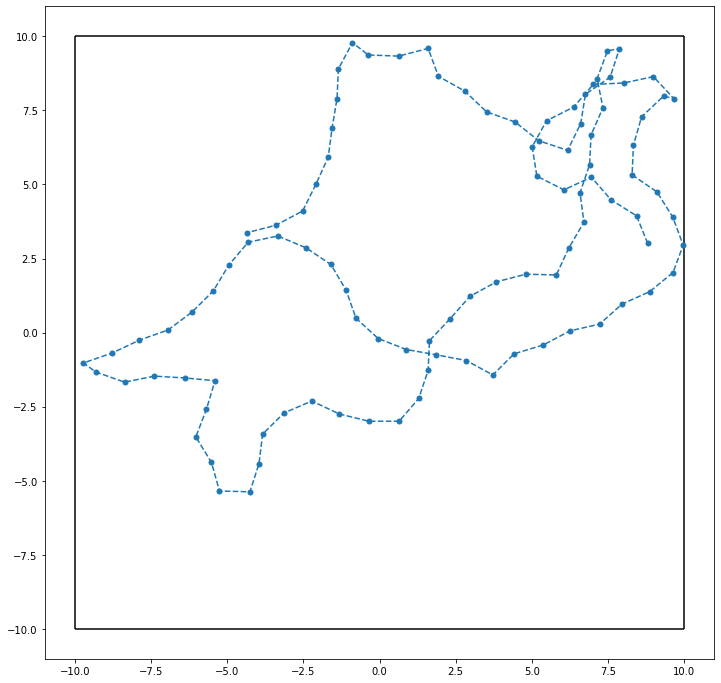

In [4]:
pos = generate_gaussian_simulations(MIN_X, MAX_X, MIN_Y, MAX_Y, N_STEPS, step_size=1, std=0.1)
plt.figure(figsize=(12,12))
plt.plot(*pos.transpose(0,1), '.--', markersize=10)
plt.vlines([MIN_X, MAX_X], MIN_Y, MAX_Y)
plt.hlines([MIN_Y, MAX_Y], MIN_X, MAX_X)

In [5]:
simulations = torch.stack([
    generate_gaussian_simulations(MIN_X, MAX_X, MIN_Y, MAX_Y, N_STEPS, 0.5, 0.1)
for i in range(N_SIMULATIONS)])

#### Save

In [159]:
torch.save(simulations, SIMULATIONS_FILE_NAME)

#### Load

In [4]:
simulations = torch.load(SIMULATIONS_FILE_NAME)
anchors_pos = torch.load(ANCHORS_FILE_NAME)

In [5]:
params = {
    'rssi_t': 60.0,
    'rssi_n': 2.0,
    'rssi_std': 5.0,
    'n_rssi_measurements': 10,
    'rtt_a': 1.1,
    'rtt_b': 10.0,
    'rtt_std': 4.0
}

In [6]:
data = SimulationData(simulations, anchors_pos, **params)

#### Visualize the data

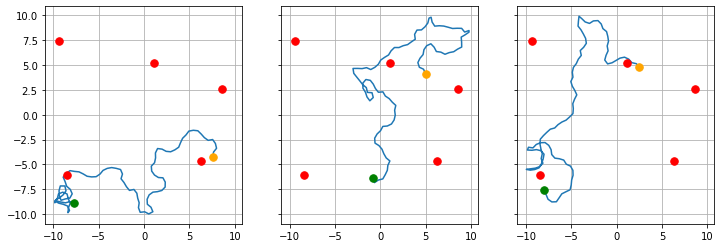

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(12,4))

data.plot_simulation(data[0][1], ax=ax1)
data.plot_simulation(data[1][1], ax=ax2)
data.plot_simulation(data[2][1], ax=ax3)

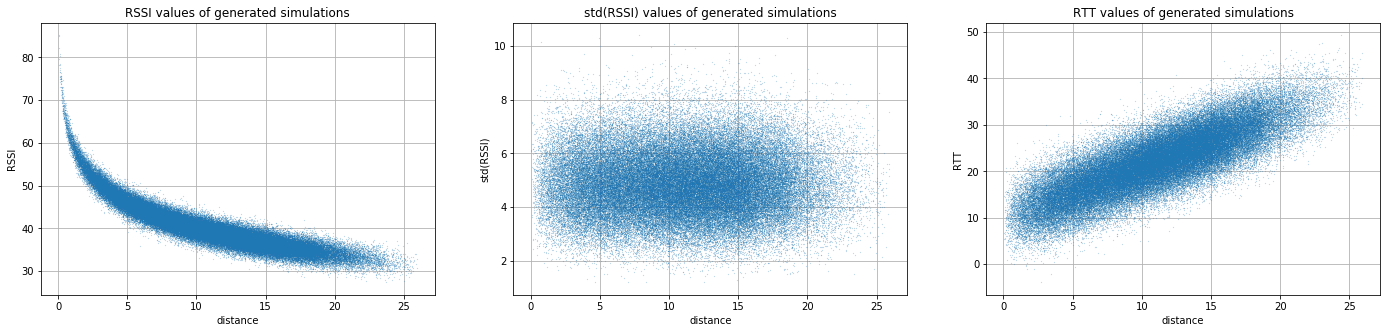

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(24, 5))

dist = data.distances.view(-1)
feat = data[:][0][:,:,:5].reshape(-1)
ax1.set_title('RSSI values of generated simulations')
ax1.grid()
ax1.set_xlabel('distance')
ax1.set_ylabel('RSSI')
ax1.plot(dist, feat, '.', markersize=0.2)

dist = data.distances.view(-1)
feat = data[:][0][:,:,5:10].reshape(-1)
ax2.set_title('std(RSSI) values of generated simulations')
ax2.grid()
ax2.set_xlabel('distance')
ax2.set_ylabel('std(RSSI)')
ax2.plot(dist, feat, '.', markersize=0.2)

dist = data.distances.view(-1)
feat = data[:][0][:,:,10:].reshape(-1)
ax3.set_title('RTT values of generated simulations')
ax3.grid()
ax3.set_xlabel('distance')
ax3.set_ylabel('RTT')
ax3.plot(dist, feat, '.', markersize=0.2);

# Generate calibration data

#### Generation

In [18]:
horizontal_sims, vertical_sims = generate_calibration_data(N_SIMULATIONS // 2, N_STEPS, [MIN_X, MAX_X], [MIN_Y, MAX_Y])

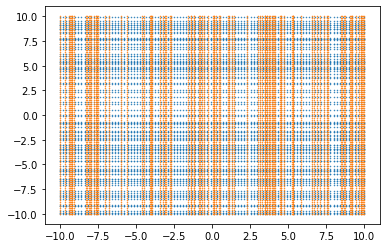

In [19]:
plt.plot(*horizontal_sims.view(-1, 2).t(), '.', markersize=1)
plt.plot(*vertical_sims.view(-1, 2).t(), '.', markersize=1)

#### Save

In [11]:
torch.save([horizontal_sims, vertical_sims], CAL_FILE_NAME)

#### Load

In [9]:
horizontal_sims, vertical_sims = torch.load(CAL_FILE_NAME)

#### Transform into dataset

In [10]:
horizontal_cal_data = SimulationData(horizontal_sims, anchors_pos)
vertical_cal_data = SimulationData(vertical_sims, anchors_pos)

# Train without calibration

In [11]:
train_loader, test_loader = data.get_random_loaders(0.8, BATCH_SIZE)
input_dim = data.feature_dim
bot_dim = 2
hid_dim = 12

### Testing different embedding dimensions

#### Train

In [14]:
bot_dims = [2,3,4,5,6]
n_dims = len(bot_dims)

In [26]:
models = {}
for bd in bot_dims:
    model = create_autoencoder_model(input_dim, hid_dim, bd)
    model = Model(model)
    optimizer = optim.Adam(model.model.parameters(), lr=0.005)
    model.train_eval(train_loader, test_loader, optimizer, 5 * N_EPOCHS)
    
    models[bd] = model

100%|██████████| 2500/2500 [09:50<00:00,  4.24it/s]


In [35]:
bd = 10

model = create_autoencoder_model(input_dim, hid_dim, bd)
model = Model(model)
optimizer = optim.Adam(model.model.parameters(), lr=0.005)
model.train_eval(train_loader, test_loader, optimizer, 5 * N_EPOCHS)

models[bd] = model

100%|██████████| 2500/2500 [09:39<00:00,  4.31it/s]


#### Save

In [27]:
for bd in bot_dims:
    path = os.path.join(RESULTS_PATH, f'pc_autoencoder_embedding_{bd}D')
    models[bd].save(path)

/home/painguin/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/painguin/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/painguin/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


#### Load 

In [15]:
models = {}
for bd in bot_dims:
    path = os.path.join(RESULTS_PATH, f'pc_autoencoder_embedding_{bd}D')
    models[bd] = Model.load(path)

In [16]:
n_dims = 5

Text(0.5, 0, 'epoch')

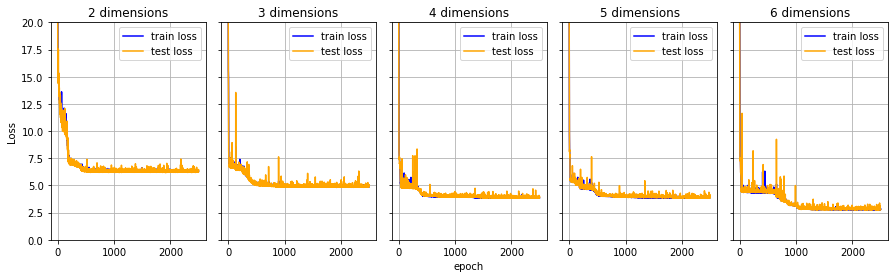

In [17]:
fig, axes = plt.subplots(nrows=(n_dims - 1) // 5 + 1, ncols=5, sharex=True, sharey=True, figsize=(15, 4))
plt.grid()
plt.subplots_adjust(wspace=0.1)

for i in range(n_dims):
    bd = bot_dims[i]
    
    ax = axes[i % 5] if n_dims <= 5 else axes[i // 5, i % 5]
    
    ax.grid(True)
    ax.plot(models[bd].train_loss, c='blue')
    ax.plot(models[bd].test_loss, c='orange')
    ax.legend(['train loss', 'test loss'])
    ax.set_title(f'{bd} dimensions')
    
plt.ylim(0, 20)
axes[0].set_ylabel('Loss')
axes[2].set_xlabel('epoch')

### Recovery loss

#### Train

In [45]:
model = create_autoencoder_model(input_dim, hid_dim, bot_dim)
model = Model(model)
optimizer = optim.Adam(model.model.parameters(), lr=0.005)
model.train_eval(train_loader, test_loader, optimizer, 5 * N_EPOCHS)

100%|██████████| 2500/2500 [10:39<00:00,  3.91it/s]


#### Save

In [46]:
path = os.path.join(RESULTS_PATH, 'pc_autoencoder_2D_embedding')
model.save(path)

/home/painguin/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/painguin/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/painguin/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


#### Load 

In [18]:
path = os.path.join(RESULTS_PATH, 'pc_autoencoder_2D_embedding')
model = Model.load(path)

#### Visualize

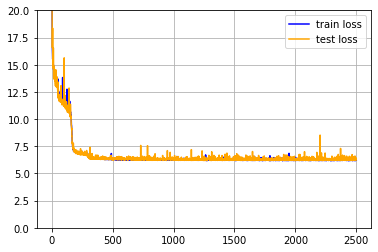

In [19]:
model.plot_loss([0,20])

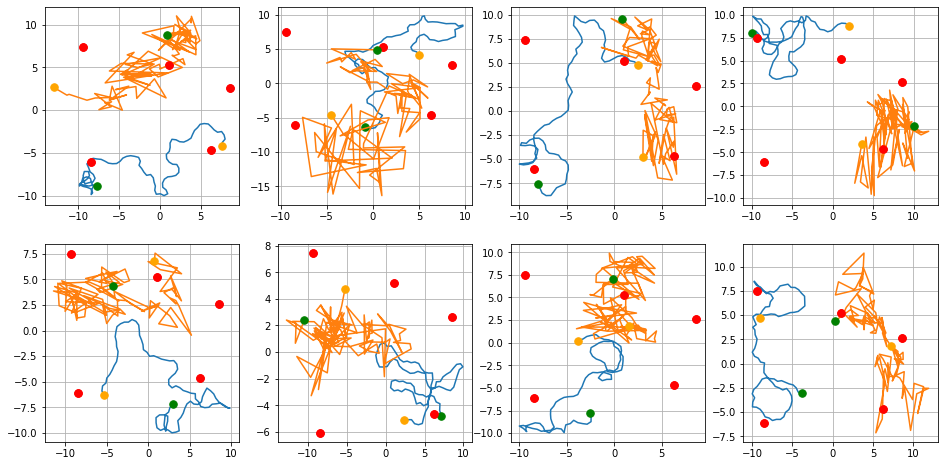

In [21]:
model.plot_embedding_on_simulation(data, range(8))

### Fixed points

#### Train

In [22]:
loss_functions = [
    {
        'name': 'reconstruction',
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'name': 'fixed points',
        'function': fixed_points_loss,
        'weight': 1.0
    }
]

model = create_autoencoder_model(input_dim, hid_dim, bot_dim)
model = ModelMultiLoss(model, loss_functions)
optimizer = optim.Adam(model.model.parameters(), lr=0.0005)
model.train_eval(train_loader, test_loader, optimizer, 3 * N_EPOCHS)

100%|██████████| 1500/1500 [08:07<00:00,  3.08it/s]


#### Save

In [29]:
path = os.path.join(RESULTS_PATH, 'pc_autoencoder_with_fixed_points')
model.save(path)

#### Load

In [22]:
path = os.path.join(RESULTS_PATH, 'pc_autoencoder_with_fixed_points')
model = ModelMultiLoss.load(path)

#### Visualize

Text(0.5, 0, 'epoch')

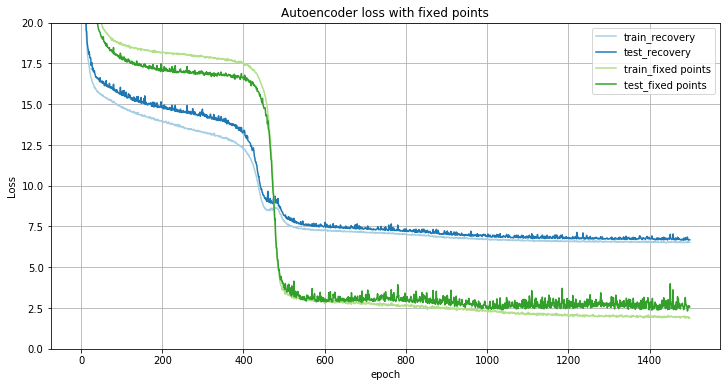

In [23]:
model.plot_loss([0,20])
plt.title('Autoencoder loss with fixed points')
plt.ylabel('Loss')
plt.xlabel('epoch')

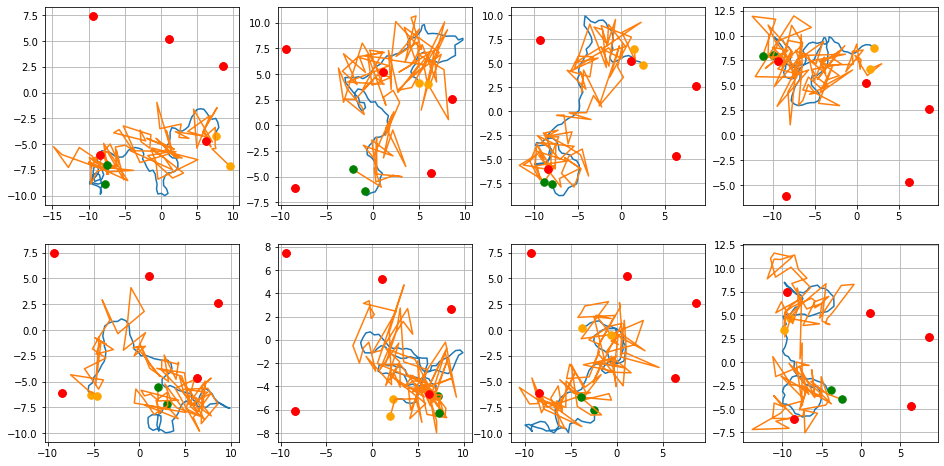

In [24]:
model.plot_embedding_on_simulation(data, range(8))

### First order finite differences

#### Train

In [16]:
loss_functions = [
    {
        'name': 'recovery',
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'name': 'fixed points',
        'function': fixed_points_loss,
        'weight': 1.0
    }, {
        'name': 'imu',
        'function': imu_loss,
        'weight': 10.0
    }
]

path = os.path.join(RESULTS_PATH, 'pc_autoencoder_with_fixed_points')
model = ModelMultiLoss.load(path)
model.change_loss_functions(loss_functions)
optimizer = optim.Adam(model.model.parameters(), lr=0.0005)
model.train_eval(train_loader, test_loader, optimizer, N_EPOCHS)

100%|██████████| 500/500 [03:14<00:00,  2.57it/s]


#### Save

In [19]:
path = os.path.join(RESULTS_PATH, 'pc_autoencoder_with_imu')
model.save(path)

/home/painguin/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/painguin/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/painguin/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


#### Load

In [28]:
path = os.path.join(RESULTS_PATH, 'pc_autoencoder_with_imu')
model = ModelMultiLoss.load(path)

#### Visualize

Text(0.5, 0, 'epoch')

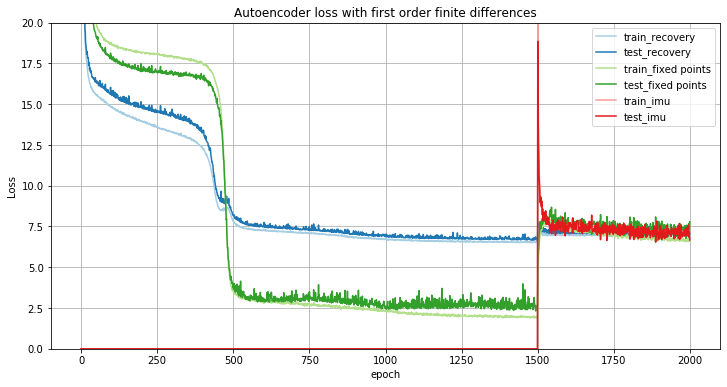

In [29]:
model.plot_loss([0,20])
plt.title('Autoencoder loss with first order finite differences')
plt.ylabel('Loss')
plt.xlabel('epoch')

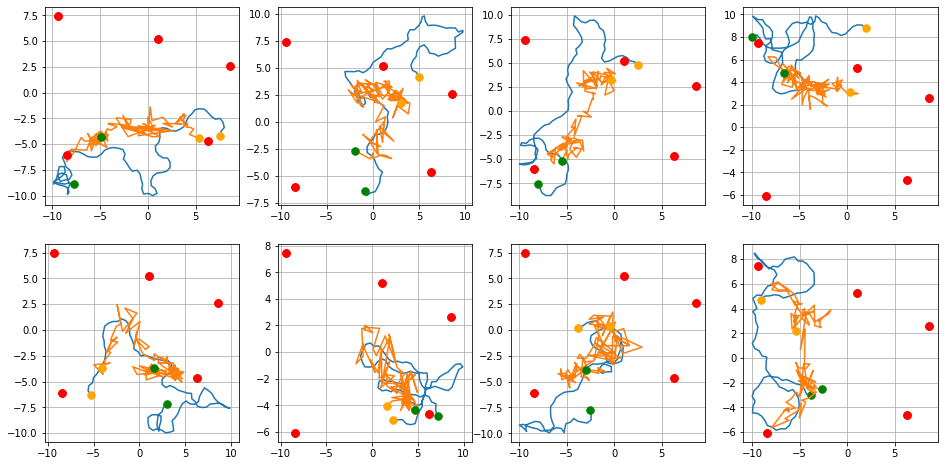

In [30]:
model.plot_embedding_on_simulation(data, range(8))

### Second order central difference

#### Train

In [26]:
loss_functions = [
    {
        'name': 'recovery',
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'name': 'fixed points',
        'function': fixed_points_loss,
        'weight': 1.0
    }, {
        'name': 'second order',
        'function': second_order_loss,
        'weight': 5.0
    }
]

path = os.path.join(RESULTS_PATH, 'pc_autoencoder_with_fixed_points')
model = ModelMultiLoss.load(path)
model.change_loss_functions(loss_functions)
optimizer = optim.Adam(model.model.parameters(), lr=0.0005)
model.train_eval(train_loader, test_loader, optimizer, N_EPOCHS)

100%|██████████| 500/500 [03:23<00:00,  2.46it/s]


#### Save

In [29]:
path = os.path.join(RESULTS_PATH, 'pc_autoencoder_second_order')
model.save(path)

#### Load

In [31]:
path = os.path.join(RESULTS_PATH, 'pc_autoencoder_second_order')
model = ModelMultiLoss.load(path)

#### Visualize

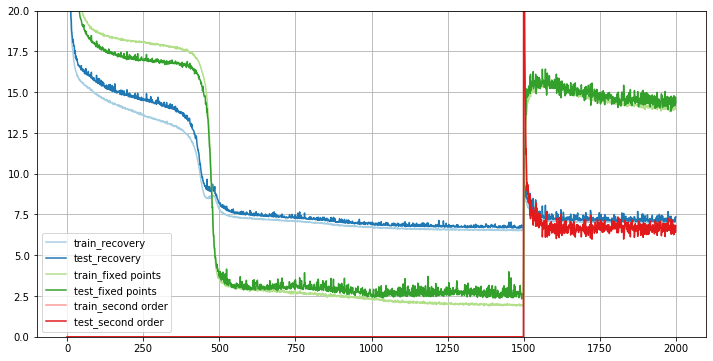

In [32]:
model.plot_loss([0,20])

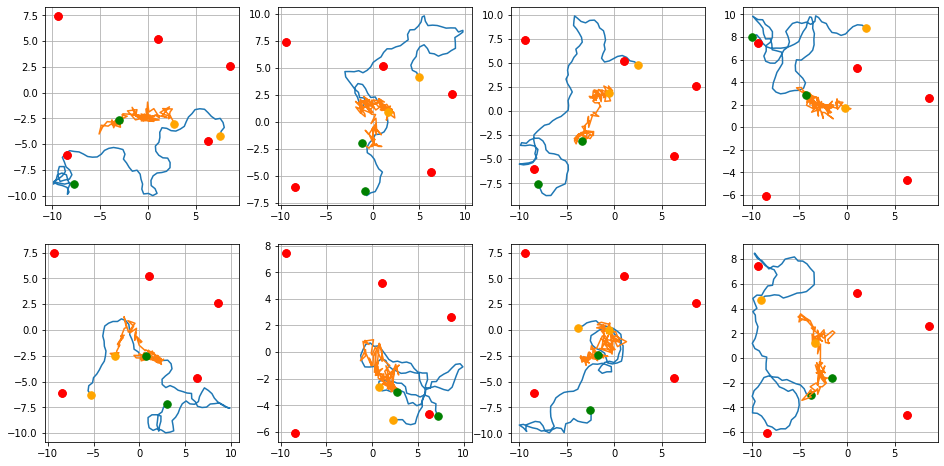

In [33]:
model.plot_embedding_on_simulation(data, range(8))

# Train with calibration

In [34]:
train_loader, test_loader = data.get_random_loaders(0.8, BATCH_SIZE)
input_dim = data.feature_dim
bot_dim = 2
hid_dim = 12

#### Train

In [16]:
loss_functions = [
    {
        'name': 'recovery',
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'name': 'fixed points',
        'function': fixed_points_loss,
        'weight': 1.0
    }
]

loss_functions_cal = [
    {
        'name': 'recovery_cal',
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'name': 'fixed_points_cal',
        'function': fixed_points_loss,
        'weight': 1.0
    }, {
        'name': 'calibration',
        'function': calibration_loss,
        'weight': 1.0
    }
]

model = create_autoencoder_model(input_dim, hid_dim, bot_dim)
model = ModelWithCalibration(model, loss_functions, loss_functions_cal)
optimizer = optim.Adam(model.model.parameters(), lr=0.001)
optimizer_cal = optim.Adam(model.model.parameters(), lr=0.001)
model.train_eval(train_loader, test_loader, optimizer, horizontal_cal_data, vertical_cal_data, optimizer_cal, 3 * N_EPOCHS)

100%|██████████| 1500/1500 [19:07<00:00,  1.31it/s]


#### Save

In [19]:
path = os.path.join(RESULTS_PATH, 'pc_autoencoder_calibration')
model.save(path)

/home/painguin/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/painguin/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/painguin/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


#### Load

In [35]:
path = os.path.join(RESULTS_PATH, 'pc_autoencoder_calibration')
model = ModelWithCalibration.load(path)

#### Visualize

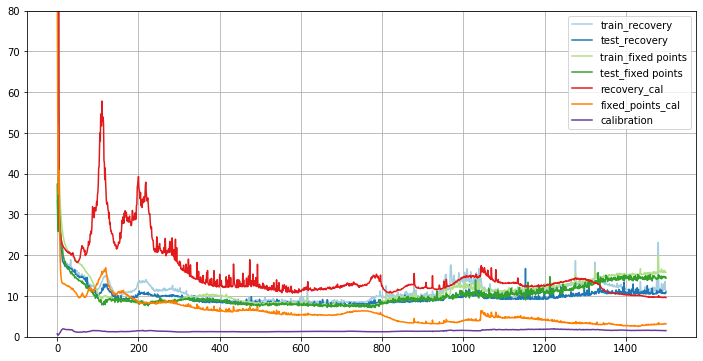

In [36]:
model.plot_loss([0,80])

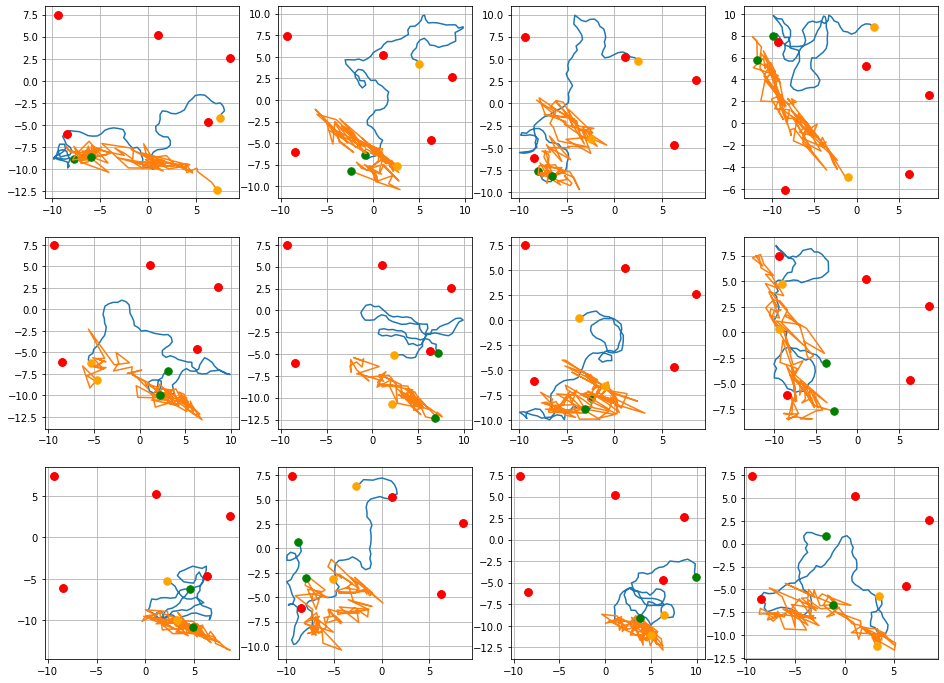

In [37]:
model.plot_embedding_on_simulation(data, range(12))

# With convolution

In [38]:
train_loader, test_loader = data.get_random_loaders(0.8, BATCH_SIZE)
input_dim = data.feature_dim
hid_dim = 12
bot_dim = 2
kernel_size = 11

#### Autoencoder architecture with convolution

In [39]:
model = create_conv_autoencoder_model(input_dim, 30, 2)
model

Sequential(
  (0): Sequential(
    (0): Conv(
      (padder): ReplicationPad1d((4, 4))
      (conv): Conv1d(15, 30, kernel_size=(9,), stride=(1,))
    )
    (1): ReLU()
    (2): Linear(in_features=30, out_features=2, bias=True)
  )
  (1): Sequential(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): ReLU()
    (2): ConvInv(
      (padder): ReplicationPad1d((4, 4))
      (conv): ConvTranspose1d(30, 15, kernel_size=(9,), stride=(1,))
    )
  )
)

### Recovery loss

#### train

In [25]:
model = create_conv_autoencoder_model(input_dim, hid_dim, bot_dim, kernel_size)
model = Model(model)
optimizer = optim.Adam(model.model.parameters(), lr=0.002)
model.train_eval(train_loader, test_loader, optimizer, 2 * N_EPOCHS)

100%|██████████| 1000/1000 [14:57<00:00,  1.11it/s]


#### Save

In [21]:
path = os.path.join(RESULTS_PATH, 'pc_convolutional_autoencoder')
model.save(path)

/home/painguin/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/painguin/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/painguin/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReplicationPad1d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/painguin/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv1d. It won't be checked for correctness upon loading.
  "type " + 

#### Load 

In [40]:
path = os.path.join(RESULTS_PATH, 'pc_convolutional_autoencoder')
model = Model.load(path)

#### Visualize

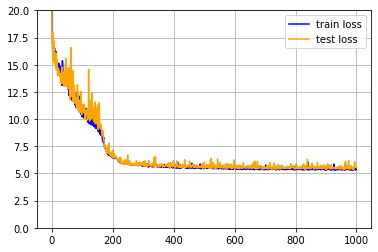

In [41]:
model.plot_loss([0,20])

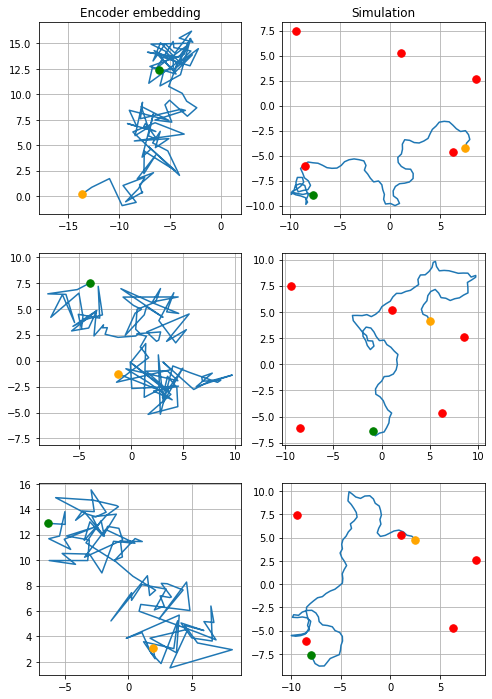

In [42]:
model.plot_embedding(data, range(3))

### Fixed points 

#### Train

In [40]:
loss_functions = [
    {
        'name': 'recovery',
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'name': 'fixed points',
        'function': fixed_points_loss,
        'weight': 1.0
    }
]

model = create_conv_autoencoder_model(input_dim, hid_dim, bot_dim, kernel_size)
model = ModelMultiLoss(model, loss_functions)
optimizer = optim.Adam(model.model.parameters(), lr=0.0005)
model.train_eval(train_loader, test_loader, optimizer, 2 * N_EPOCHS)

100%|██████████| 1000/1000 [17:00<00:00,  1.02s/it]


#### Save

In [43]:
path = os.path.join(RESULTS_PATH, 'pc_conv_autoencoder_with_fixed_points')
model.save(path)

/home/painguin/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/painguin/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReplicationPad1d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/painguin/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv1d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/painguin/miniconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ConvInv. It won't be checked for correctness upon loading.
  "type " + obj

#### Load

In [43]:
path = os.path.join(RESULTS_PATH, 'pc_conv_autoencoder_with_fixed_points')
model = ModelMultiLoss.load(path)

#### Visualize

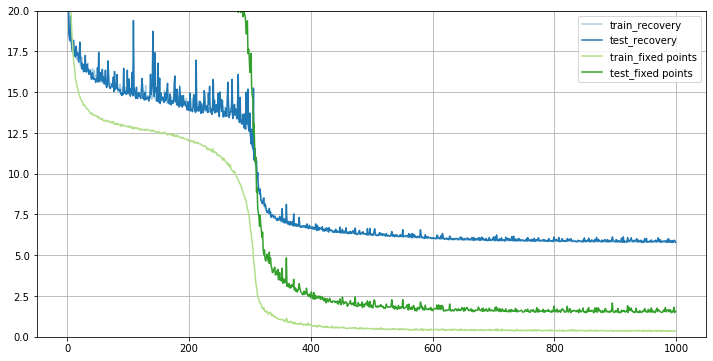

In [44]:
model.plot_loss([0,20])

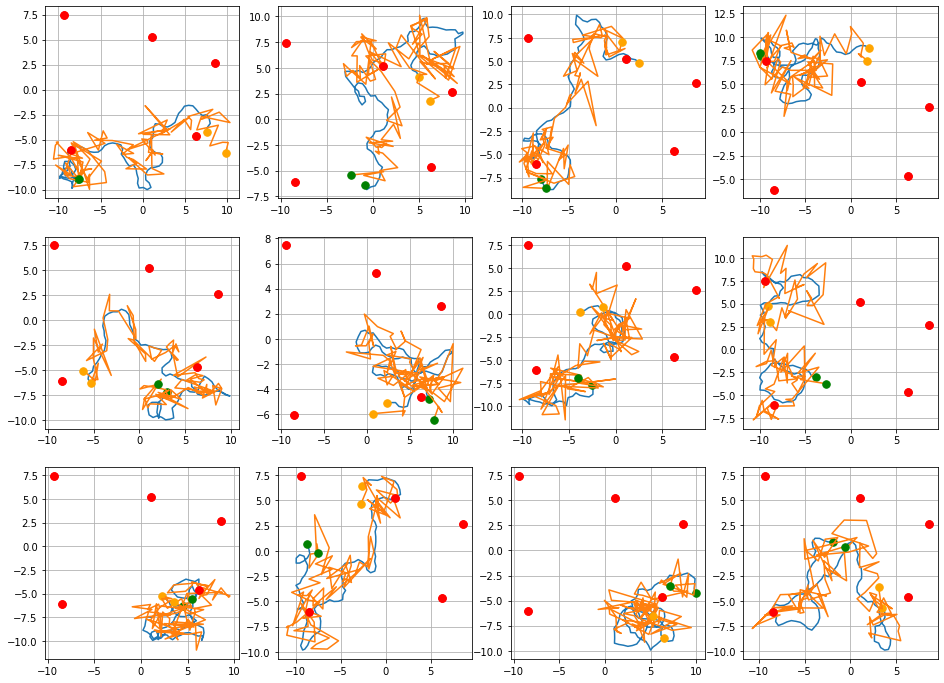

In [45]:
model.plot_embedding_on_simulation(data, range(12))

### First order finite differences

#### Train

In [64]:
loss_functions = [
    {
        'name': 'recovery',
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'name': 'fixed points',
        'function': fixed_points_loss,
        'weight': 1.0
    }, {
        'name': 'imu',
        'function': imu_loss,
        'weight': 10.0
    }
]

path = os.path.join(RESULTS_PATH, 'pc_conv_autoencoder_with_fixed_points')
model = ModelMultiLoss.load(path)
model.change_loss_functions(loss_functions)
optimizer = optim.Adam(model.model.parameters(), lr=0.001)
model.train_eval(train_loader, test_loader, optimizer, N_EPOCHS)

100%|██████████| 500/500 [09:10<00:00,  1.10s/it]


#### Save

In [65]:
path = os.path.join(RESULTS_PATH, 'pc_conv_autoencoder_with_imu')
model.save(path)

#### Load

In [46]:
path = os.path.join(RESULTS_PATH, 'pc_conv_autoencoder_with_imu')
model = ModelMultiLoss.load(path)

#### Visualize

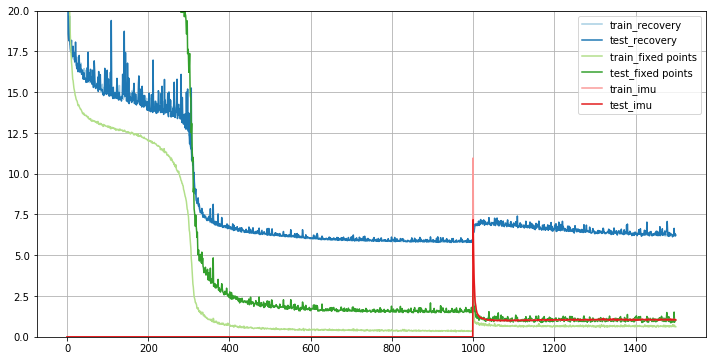

In [47]:
model.plot_loss([0,20])

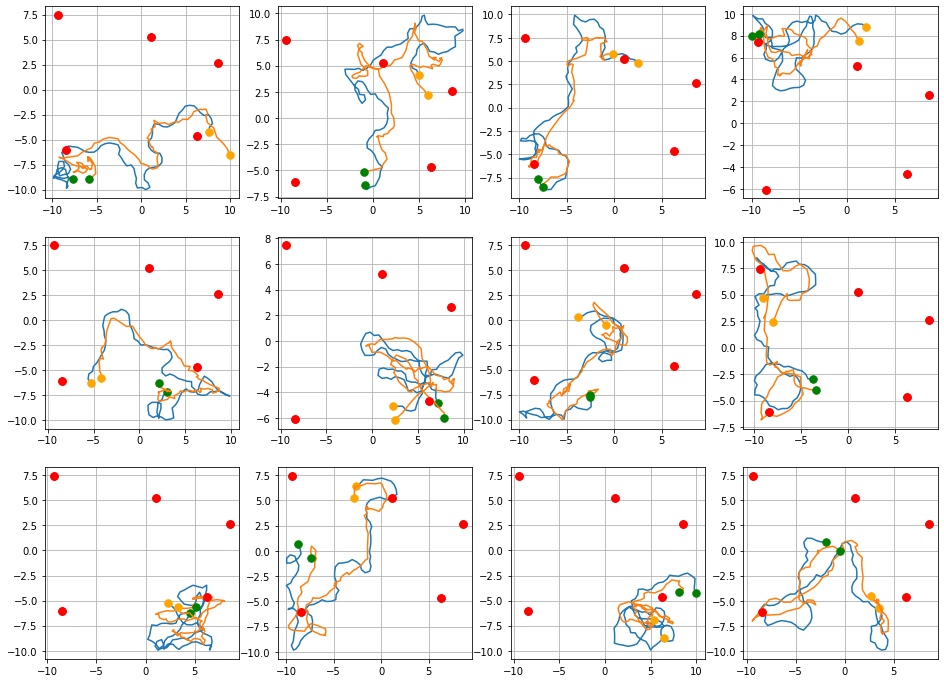

In [48]:
model.plot_embedding_on_simulation(data, range(12))

#### Visualize filters

In [49]:
filters = model.model[0][0].conv.weight
filters.size()

torch.Size([12, 15, 11])

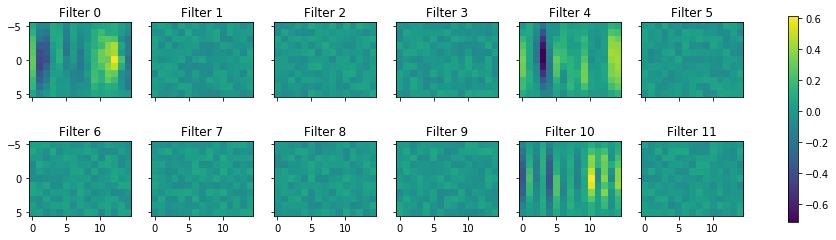

In [50]:
max_val = filters.max().item()
min_val = filters.min().item()

fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(16,4), sharex=True, sharey=True)

for i in range(12):
    data_ = filters[i].detach().numpy().T[::-1]
    ax = axes[i // 6, i % 6]
    ah = ax.imshow(data_, extent=[-0.5, 14.5, 5.5, -5.5], vmin=min_val, vmax=max_val)
    ax.set_title(f'Filter {i}')
    
cbar = fig.colorbar(ah, ax=axes.ravel().tolist(), shrink=0.95)

#### Visualize recovered output 

In [52]:
start_anchor_idx = 4 # anchor 5
end_anchor_idx = 2 # anchor 3
start = anchors_pos[start_anchor_idx]
end = anchors_pos[end_anchor_idx]
start, end

(tensor([-8.4717, -6.0705]), tensor([1.0829, 5.2221]))

In [61]:
# walk from one point to the other
t = torch.linspace(0.05, 0.95, 50)
interpolation = ((1 - t) * start.unsqueeze(1) + t * end.unsqueeze(1)).T
output = model.model[1](interpolation).detach().T

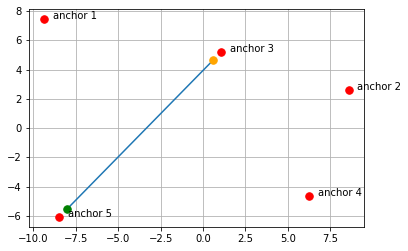

In [62]:
data.plot_simulation(interpolation)
for i in range(5):
    plt.text(anchors_pos[i,0] + 0.5, anchors_pos[i,1], f'anchor {i + 1}')

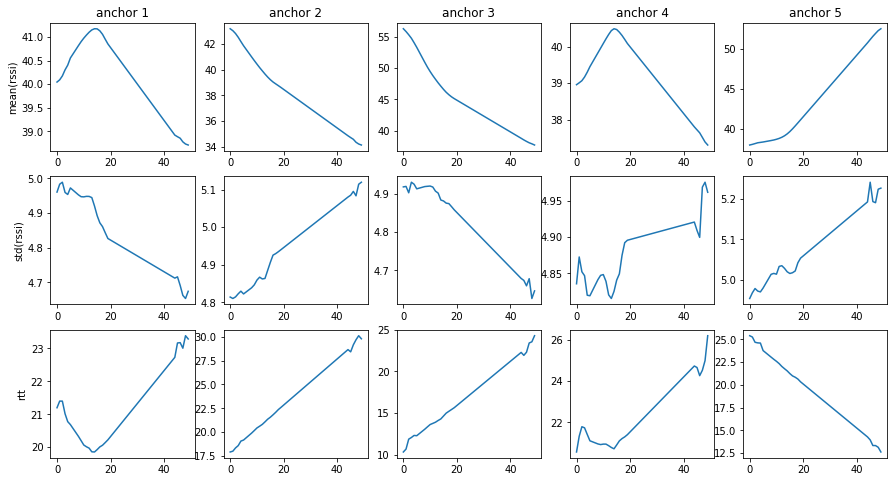

In [114]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,8))

for i in range(15):
    ax = axes[i // 5, i % 5]
    ax.plot(output[i].numpy().T[::-1])
    
for i in range(5):
    axes[0,i].set_title(f'anchor {i + 1}')

axes[0,0].set_ylabel('mean(rssi)')
axes[1,0].set_ylabel('std(rssi)')
axes[2,0].set_ylabel('rtt');

### Second order

#### Train

In [20]:
loss_functions = [
    {
        'name': 'recovery',
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'name': 'fixed points',
        'function': fixed_points_loss,
        'weight': 1.0
    }, {
        'name': 'second order',
        'function': second_order_loss,
        'weight': 10.0
    }
]

path = os.path.join(RESULTS_PATH, 'pc_conv_autoencoder_with_fixed_points')
model = ModelMultiLoss.load(path)
model.change_loss_functions(loss_functions)
optimizer = optim.Adam(model.model.parameters(), lr=0.001)
model.train_eval(train_loader, test_loader, optimizer, N_EPOCHS)

100%|██████████| 500/500 [07:14<00:00,  1.15it/s]


#### Save

In [21]:
path = os.path.join(RESULTS_PATH, 'pc_conv_autoencoder_with_second_order')
model.save(path)

#### Load

In [63]:
path = os.path.join(RESULTS_PATH, 'pc_conv_autoencoder_with_second_order')
model = ModelMultiLoss.load(path)

#### Visualize

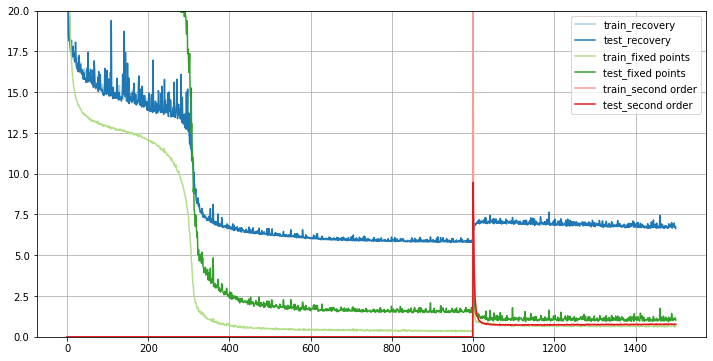

In [64]:
model.plot_loss([0,20])

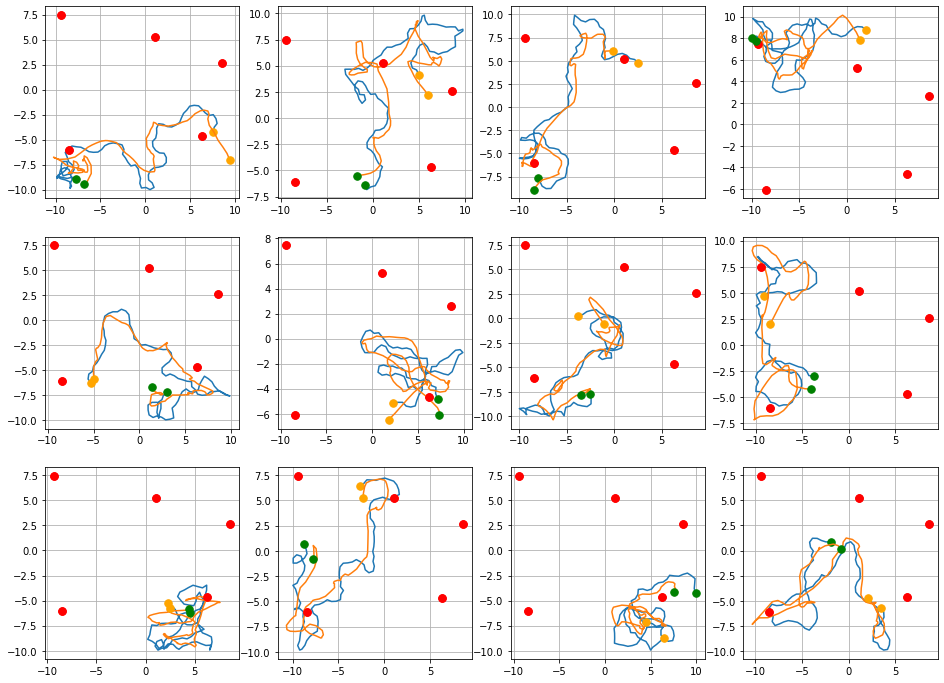

In [65]:
model.plot_embedding_on_simulation(data, range(12))

### With both first and second order

#### Train

In [25]:
loss_functions = [
    {
        'name': 'recovery',
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'name': 'fixed points',
        'function': fixed_points_loss,
        'weight': 1.0
    }, {
        'name': 'second order',
        'function': second_order_loss,
        'weight': 10.0
    }, {
        'name': 'imu',
        'function': imu_loss,
        'weight': 10.0
    }
]

path = os.path.join(RESULTS_PATH, 'pc_conv_autoencoder_with_fixed_points')
model = ModelMultiLoss.load(path)
model.change_loss_functions(loss_functions)
optimizer = optim.Adam(model.model.parameters(), lr=0.001)
model.train_eval(train_loader, test_loader, optimizer, N_EPOCHS)

100%|██████████| 500/500 [07:44<00:00,  1.08it/s]


#### Save

In [26]:
path = os.path.join(RESULTS_PATH, 'pc_conv_autoencoder_all')
model.save(path)

#### Load

In [66]:
path = os.path.join(RESULTS_PATH, 'pc_conv_autoencoder_all')
model = ModelMultiLoss.load(path)

#### Visualize

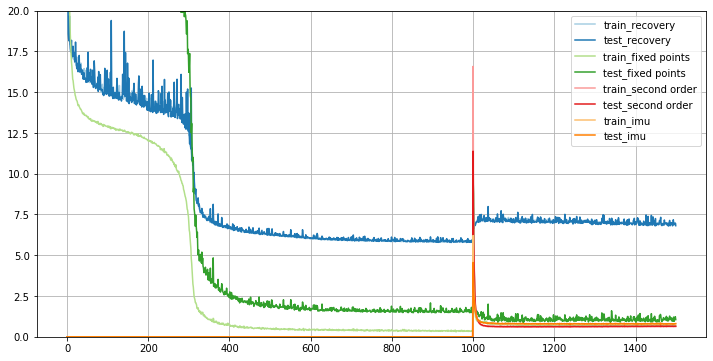

In [67]:
model.plot_loss([0,20])

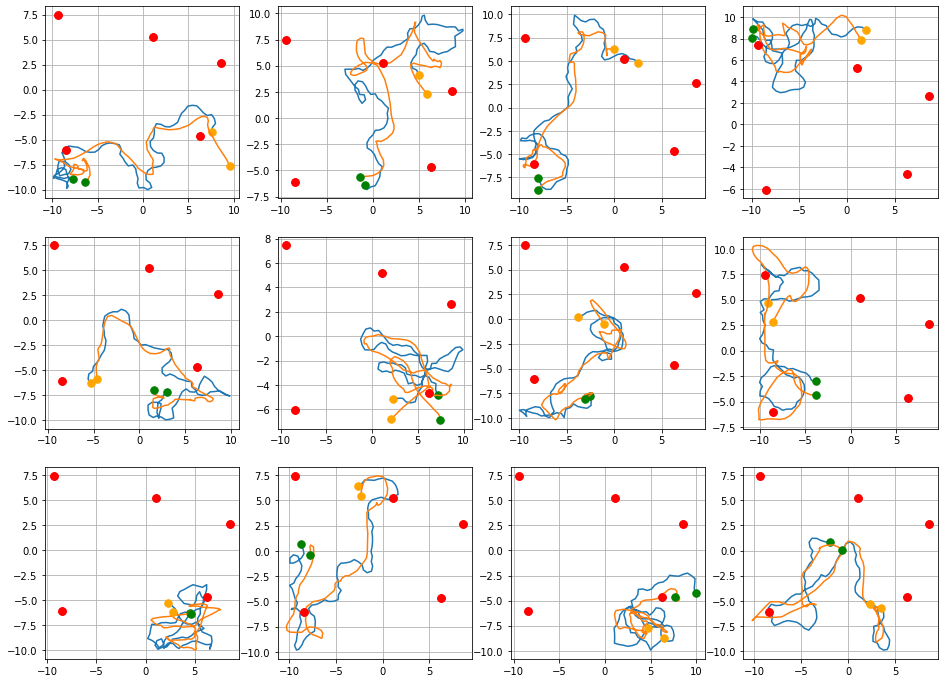

In [68]:
model.plot_embedding_on_simulation(data, range(12))

### With calibration

#### Train 

In [30]:
loss_functions = [
    {
        'name': 'recovery',
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'name': 'fixed points',
        'function': fixed_points_loss,
        'weight': 1.0
    }, {
        'name': 'second order',
        'function': second_order_loss,
        'weight': 10.0
    }
]

loss_functions_cal = [
    {
        'name': 'recovery_cal',
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'name': 'fixed_points_cal',
        'function': fixed_points_loss,
        'weight': 1.0
    }, {
        'name': 'calibration',
        'function': calibration_loss,
        'weight': 1.0
    }
]

path = os.path.join(RESULTS_PATH, 'pc_conv_autoencoder_with_fixed_points')
model = ModelMultiLoss.load(path)
model = ModelWithCalibration.from_ModelMultiLoss(model, loss_functions, loss_functions_cal)
optimizer = optim.Adam(model.model.parameters(), lr=0.001)
optimizer_cal = optim.Adam(model.model.parameters(), lr=0.001)
model.train_eval(train_loader, test_loader, optimizer, horizontal_cal_data, vertical_cal_data, optimizer_cal, 2 * N_EPOCHS)

100%|██████████| 1000/1000 [31:01<00:00,  1.86s/it]


#### Save

In [31]:
path = os.path.join(RESULTS_PATH, 'pc_conv_autoencoder_cal_all')
model.save(path)

#### Load

In [69]:
path = os.path.join(RESULTS_PATH, 'pc_conv_autoencoder_cal_all')
model = ModelMultiLoss.load(path)

#### Visualize

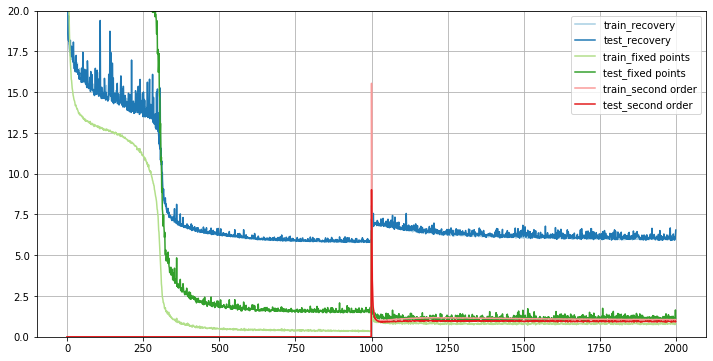

In [70]:
model.plot_loss([0,20])

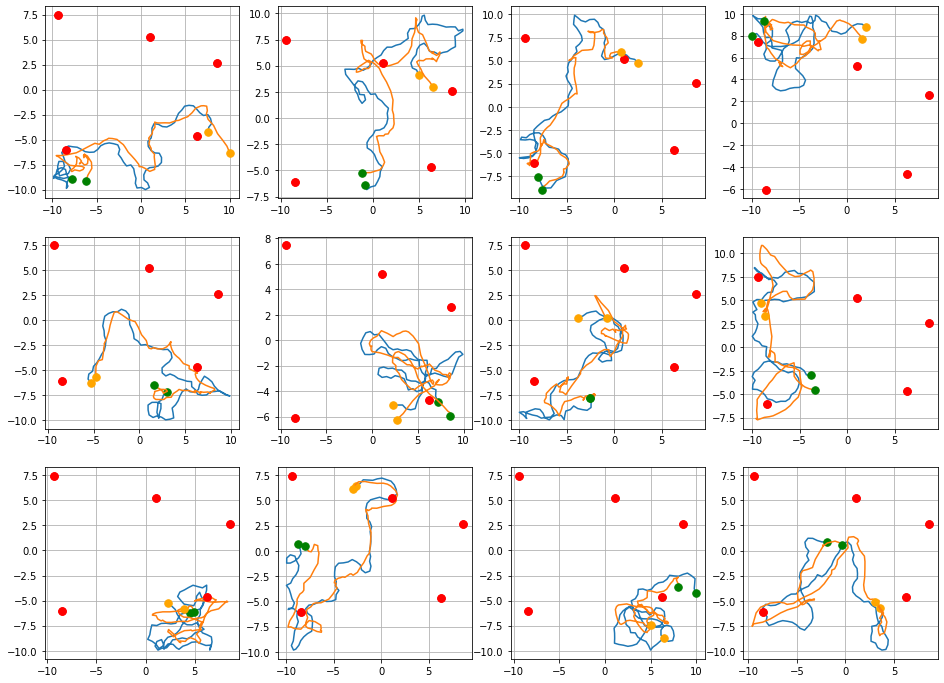

In [71]:
model.plot_embedding_on_simulation(data, range(12))